# 30s Dataset

## Dataset

Here we create the dataset

In [71]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
   
class GTZANFeaturesDataset(Dataset):
    def __init__(self, features_file, transform=None, target_transform=None):
        """
        Args:
            features_file (string): Path to the csv file with features.
            img_dir (string): Directory with all the spectrogram images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        # We drop the feature related to the length of the audio file
        self.features_frame = pd.read_csv(features_file).drop('length', axis=1)         
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.features_frame)


    def __getitem__(self, idx):
        # Load features
        features = self.features_frame.iloc[idx, 1:-1].to_numpy()
        #print(features.shape)
        features = features.astype('float')#.reshape(-1, 1)

        # Load label
        label = self.features_frame.iloc[idx, -1]


        if self.transform:
            features = self.transform(features)
        if self.target_transform:
            label = self.target_transform(label)

        # print(features.shape, label.shape)
        return features.float(), label

In [72]:
# Path to the csv file with the features
features_file = 'Data\\features_30_sec.csv'

### Custom Transformations for the dataset

Here we create some custom trasnformation for our dataset

In [73]:
# This is a custom transform to normalize the features
class CustomNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, numpy_array):
        normalized_data = (numpy_array - self.mean) / self.std

        tensor = torch.from_numpy(normalized_data)
        return tensor
    

# Here we compute the mean and the std of the features
data = pd.read_csv(features_file).drop(columns=['filename', 'length', 'label'])
mean = data.mean().to_numpy()
std = data.std().to_numpy()

custom_norm = CustomNormalize(mean=mean, std=std)

This trasformation encodes the labels in a one hot vector

In [74]:
class LabelTransform:
    def __init__(self, label_set):
        # Map each of the first 10 letters of the alphabet to an index
        self.label_to_index = {label: index for index, label in enumerate(label_set)}

    def __call__(self, label):
        # Initialize a one-hot encoded tensor of size 10 (for 10 classes)
        one_hot = torch.zeros(10, dtype=torch.float)
        # Set the appropriate position to 1 based on the label index
        label_index = self.label_to_index[label]
        one_hot[label_index] = 1.0
        # return one_hot
        return self.label_to_index[label]
    

labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']
# Example usage of the transform
label_transform = LabelTransform(labels)


Here we instantiate the actual transformations

In [75]:
# Define a transform to convert the images to tensors and normalize them
target_transform = label_transform

transform_norm = custom_norm

Here we are creating the training and test dataset


In [76]:
# Create the dataset
gtzan_dataset = GTZANFeaturesDataset(features_file=features_file, transform=transform_norm, target_transform=target_transform)

# Split the dataset into training and test sets
training_data, test_data = torch.utils.data.random_split(gtzan_dataset, [800, 200])

# Create data loaders
batch_size = 50
shuffle = True
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)         # Each element in the dataloader iterable will return a batch of 64 features and labels.
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle)                       # We need to use a batch size of 1 to test the model!!!

## Creating the Model

To build this model we used the official pytorch tutorials

In [77]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()                      # This lines assign the 'nn.Flatten()' function to the 'flatten' attribute (that will be called in the forward pass)
        
        # 4 Hidden layers
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(57, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10),
        )

    # Here we define the behaviour of the forward pass
    def forward(self, x):
        #x = self.flatten(x)                             
        logits = self.linear_relu_stack(x)               # 'logits' are the raw output of the final layer in the NN
        return logits                                    #  (the pre activations of the last layer before applying the last activation function (like softmax))


# Our model
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=57, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
)


## Training the model

Here we choose the optimizers

In [78]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-4)

Training loop: the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.  (code from the official pytorch tutorials)

In [79]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Sets the model in 'training' mode
    model.train()                                        #  This helps inform layers such as Dropout and BatchNorm, which are
                                                         #   designed to behave differently during training and evaluation.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)               # '.to(device)' allows you to move the data to the device you are using (ex. GPU memory)

        # Compute prediction error
        pred = model(X)
        # print(X.shape, y.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()                            # This command resets the gradients (pytorch acumulates them by default)


    print(f"loss: {loss:>7f}")
    return loss.item()            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [80]:
def test_loss(dataloader, model, loss_fn):
    num_batches = len(dataloader)                   # c'e' un problema, il batch è 10!!!

    # Sets the model in 'evaluation' mode
    model.eval()

    test_loss = 0

    # Temporarily disable gradients computation
    with torch.no_grad():                                 # This disables the memorization of the activation functions during the forward pass
        for X, y in dataloader:                           #  (they are used in the backprop phase to compute the gradients)
            X, y = X.to(device), y.to(device)     
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [81]:
def test_accuracy(dataloader, model):
    size = len(dataloader.dataset)


    # Sets the model in 'evaluation' mode
    model.eval()

    correct = 0

    # Temporarily disable gradients computation
    with torch.no_grad():                                 # This disables the memorization of the activation functions during the forward pass
        for X, y in dataloader:                           #  (they are used in the backprop phase to compute the gradients)
            X, y = X.to(device), y.to(device)     
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()     # The prediction is the argmax of the last layer
    correct /= size 
    return correct

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%")
    # return correct

Training process

Epoch 1
-------------------------------
loss: 2.275511
Epoch 2
-------------------------------
loss: 2.288922
Epoch 3
-------------------------------
loss: 2.288146
Epoch 4
-------------------------------
loss: 2.247730
Epoch 5
-------------------------------
loss: 2.234248
Epoch 6
-------------------------------
loss: 2.185281
Epoch 7
-------------------------------
loss: 2.138880
Epoch 8
-------------------------------
loss: 2.009865
Epoch 9
-------------------------------
loss: 1.843815
Epoch 10
-------------------------------
loss: 2.036180
Epoch 11
-------------------------------
loss: 1.886445
Epoch 12
-------------------------------
loss: 1.814222
Epoch 13
-------------------------------
loss: 1.797106
Epoch 14
-------------------------------
loss: 1.603254
Epoch 15
-------------------------------
loss: 1.652164
Epoch 16
-------------------------------
loss: 1.689610
Epoch 17
-------------------------------
loss: 1.788060
Epoch 18
-------------------------------
loss: 1.740116
E

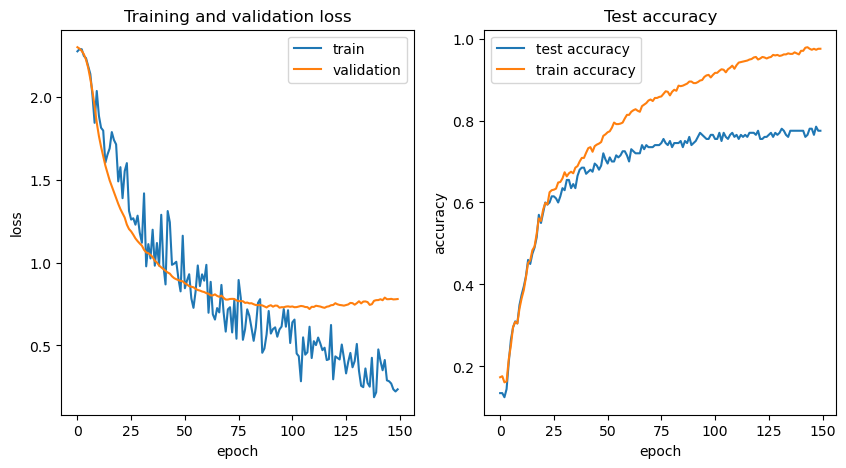

In [82]:
epochs = 150

# Histories
train_history = list()
validation_history = list()
accuracy_test_history = list()
accuracy_train_history = list()

# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    validation_loss = test_loss(test_dataloader, model, loss_fn)


    train_history.append(train_loss)
    validation_history.append(validation_loss)
    accuracy_test_history.append(test_accuracy(test_dataloader, model))
    accuracy_train_history.append(test_accuracy(train_dataloader, model))
print("Done!")

print(f"{test_accuracy(test_dataloader, model)*100:.2f}%")


# Plots
fig, axs = plt.subplots(1,2, figsize=(10, 5))

# Training and validation loss
axs[0].plot(train_history, label = 'train')
axs[0].plot(validation_history, label = 'validation')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")
axs[0].set_title("Training and validation loss")
axs[0].legend()

# Accuracy
axs[1].plot(accuracy_test_history, label = 'test accuracy')
axs[1].plot(accuracy_train_history, label = 'train accuracy')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].set_title("Test accuracy")
axs[1].legend()

# Saving the models

This code saves the full model:

In [83]:
torch.save(model, 'models\\model_weights_30_s.pth')

To Load and use the model do:

In [84]:
model = torch.load('models\\model_weights_30_s.pth')
#model.eval()  # Set the model to evaluation mode